In [1]:
%env THEANO_FLAGS=device=gpu2
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")

env: THEANO_FLAGS=device=gpu2


In [2]:
from utils.southpark import get_conversations
conversations = get_conversations("/srv/hd7/jheuristic/cartman/sp.json")
    
from utils.preprocessor import Preprocessor

preproc = Preprocessor.from_conversations(conversations,verbose=True)


100%|██████████| 7285/7285 [00:03<00:00, 2067.53it/s]


23281 out of 23281 tokens, coverage=1.00000)


# model

In [3]:
from models.twoline_model import ConversationModel
model = ConversationModel(preproc,bottleneck_size=512)

Using gpu device 2: Tesla K40m (CNMeM is disabled, cuDNN Version is too old. Update to v5, was 4004.)
/home/jheuristic/thenv/local/lib/python2.7/site-packages/agentnet/agent/recurrence.py:228: UserWarning: You are giving Recurrence an input sequence of undefined length (None).
Make sure it is always above <unspecified>(n_steps) you specified for recurrence
  "Make sure it is always above {}(n_steps) you specified for recurrence".format(n_steps or "<unspecified>"))
/home/jheuristic/thenv/local/lib/python2.7/site-packages/agentnet/agent/recurrence.py:453: UserWarning: Warning: recurrent loop without unroll_scan got nonempty random state updates list. That happened because there is some source of randomness (e.g. dropout) inside recurrent step graph. To compile such graph, one must either call .get_automatic_updates() right after .get_output and pass these updates to a function, or use no_defalt_updates=True when compiling theano.function.
  warn("Warning: recurrent loop without unroll_sc

# training

In [4]:
max_len=10
batch_size=100
n_epochs=100

In [5]:
from utils.generate import get_phrase_pairs,iterate_minibatches

convs_ix = list(preproc.preprocess_conversations(conversations,verbose=True,max_len=max_len))

prev_phrases,reference_answers = get_phrase_pairs(convs_ix,
                                                  speaker_filter = lambda s1,s2: 'cartman' in s2).swapaxes(0,1).astype('int32')




100%|██████████| 7285/7285 [00:04<00:00, 1654.84it/s]


In [10]:
epoch_counter = 1
ce = []

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
for _ in range(n_epochs):
    for b_x,b_y in iterate_minibatches([prev_phrases,reference_answers],batch_size,shuffle=True):
        ce.append(model.train_fun(b_x,b_y))
        
        epoch_counter +=1
        
        if epoch_counter %25==0:
            print epoch_counter,'iterations...'
    print "beginning new loop..."
    plt.plot(ce)
    plt.show()
    
    ph =preproc.ix_to_phrase(b_x[0])
    print 'A:', ph
    print 'B:', model.reply(ph)
    print 'B true:',preproc.ix_to_phrase(b_y[0])
        

In [15]:
from agentnet.utils.persistence import save
save(model.decoder_training_rec,"/srv/hd7/jheuristic/agentnet_snapshots/southpark_simple_cm_cartman_epoch%i.pcl"%epoch_counter)

# apply

In [6]:
from agentnet.utils.persistence import load
load(model.decoder_training_rec,"/srv/hd7/jheuristic/agentnet_snapshots/southpark_simple_cm_cartman_epoch15484.pcl")

In [244]:
synthecised_phrases = model.apply_fun(prev_phrases)
import numpy as np
disc_prev_phrase = np.vstack([prev_phrases,prev_phrases])
disc_phrase = np.vstack([synthecised_phrases[:,:max_len],reference_answers])
disc_y = np.vstack([np.zeros_like(synthecised_phrases[:,:max_len]),np.ones_like(reference_answers)])


In [245]:
disc_prev_phrase = np.vstack([prev_phrases,prev_phrases])
disc_phrase = np.vstack([synthecised_phrases[:,:max_len],reference_answers])
disc_y = np.vstack([np.zeros_like(synthecised_phrases[:,:max_len]),np.ones_like(reference_answers)])


In [277]:
import theano
import theano.tensor as T
import lasagne
from lasagne.layers import *
class Discriminator:
    def __init__(self):
        prev_phrases = T.imatrix("disc input prev_phrases")
        phrases = T.imatrix("disc input phrases") 
        
        
        both_phrases = T.concatenate([prev_phrases,phrases],axis=1)
        self.l_in = InputLayer((None,None),both_phrases)
        
        self.l_mask = InputLayer((None,None),T.neq(both_phrases,preproc.token_to_ix["PAD"]))
        
        l_emb = EmbeddingLayer(self.l_in,len(preproc.tokens),128)
        
        gru_size=512
        l_gru0 = GRULayer(l_emb,gru_size,mask_input=self.l_mask,grad_clipping=5)

        l_gru0_flat = ReshapeLayer(l_gru0,(-1,gru_size))

        self.l_disc_out = DenseLayer(l_gru0_flat,1,nonlinearity=lasagne.nonlinearities.sigmoid)

        self.disc_output = get_output(self.l_disc_out).reshape(both_phrases.shape)[:,prev_phrases.shape[1]:]
        
        target_y = T.imatrix()
        
        offset = 0.01
        self.disc_output = offset + self.disc_output*(1-offset*2) 
        
        loss = lasagne.objectives.binary_crossentropy(self.disc_output,target_y).mean()
        
        self.params = get_all_params(self.l_disc_out,trainable=True)
        
        updates = lasagne.updates.adam(loss,self.params)
        
        self.train_fun = theano.function([prev_phrases,phrases,target_y],loss,updates=updates)
        
        self.predict_fun = theano.function([prev_phrases,phrases],self.disc_output)
    def discriminate(prev_phrases,phrases):#symbolic discriminator applier
        
        both_phrases = T.concatenate([prev_phrases,phrases],axis=1)
        inputs_dict = {self.l_in:both_phrases,self.l_mask:T.neq(both_phrases,preproc.token_to_ix["PAD"])}
        
        return get_output(self.disc_output,inputs_dict)

disc = Discriminator()
        
        

In [278]:
import matplotlib.pyplot as plt
%matplotlib inline 
disc_ce = []

In [279]:
def train_discriminator(epochs=100):
    for eph in range(epochs):
        for b_prev,b_phrase, b_y in iterate_minibatches([disc_prev_phrase,disc_phrase,disc_y],25,shuffle=True):
            disc_ce.append(disc.train_fun(b_prev,b_phrase, b_y))
        print eph
        plt.plot(disc_ce)
        plt.show()

0


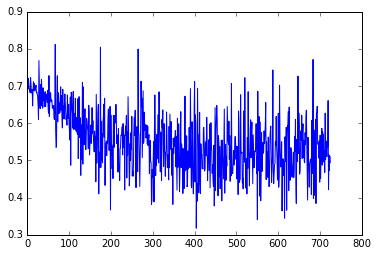

1


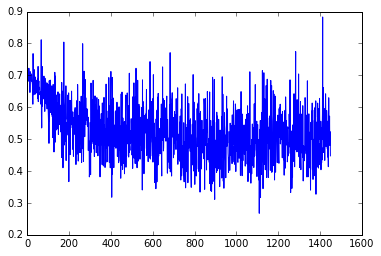

2


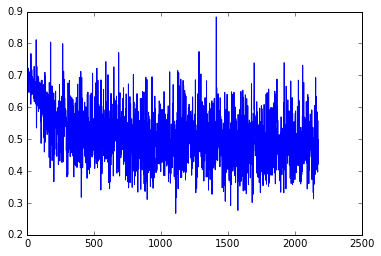

3


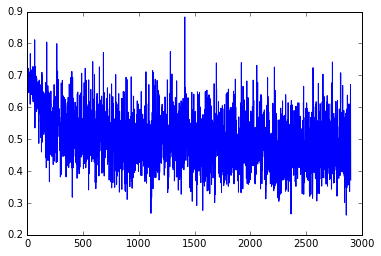

4


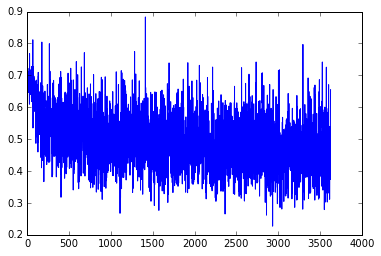

5


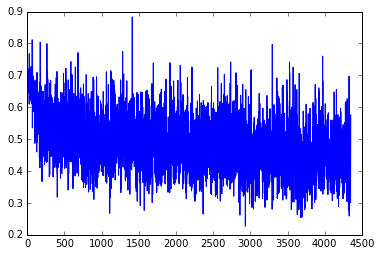

6


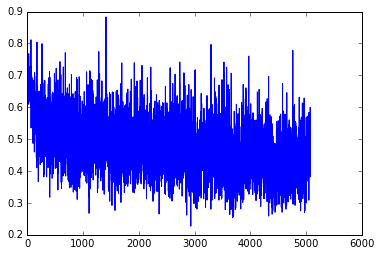

7


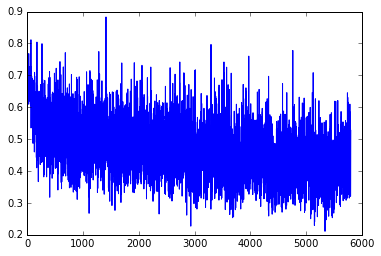

KeyboardInterrupt: 

In [280]:
train_discriminator(10)

In [270]:
from agentnet.agent import Recurrence

from agentnet.learning import a2c_n_step
from collections import OrderedDict

def build_a2c_agent(self,encoder_output,max_steps=10,
                    get_rewards=lambda prev_phrase,action_seq:T.zeros_like(action_seq,dtype='floatX')):
    
    if not hasattr(self,'decoder_step'):
        raise ValueError("Please build_decoder_step first")
        
    #build state values layer
    dec_prev_word,dec_memory,dec_probas,dec_next_word = self.decoder_step
    
    gru0 = dec_memory.keys()[0]
    
    self.V_layer = flatten(DenseLayer(gru0,1,
                              nonlinearity=None,
                              name='predicted state values'),outdim=1)
    
        
    recurrent_states = OrderedDict(dec_memory)
    recurrent_states[dec_next_word] = dec_prev_word
        
    mdp_recurrence = Recurrence(state_variables=recurrent_states,
                                      tracked_outputs=(dec_probas,dec_next_word,self.V_layer),
                                      batch_size=self.batch_size,
                                      n_steps = max_steps,
                                      unroll_scan=False,
                                      state_init = {dec_memory.keys()[0]:encoder_output})
    
    params = get_all_params(mdp_recurrence,trainable=True)

    state_seqs, (probas_seq,output_tokens_seq,V_seq_layer) = mdp_recurrence.get_sequence_layers()
    
    
    policy_seq,actions_seq,V_seq = get_output([probas_seq,output_tokens_seq,V_seq_layer])        
    self.mdp_auto_updates = mdp_recurrence.get_automatic_updates()#must be called right after get_output
    
    rewards_seq = get_rewards(self.prev_phrase,actions_seq)
    a2c_objective = a2c_n_step.get_elementwise_objective(policy_seq,V_seq,actions_seq,rewards_seq)
    
    loss = a2c_objective.mean()
    
    
    updates = lasagne.updates.adadelta(loss,params)
    
    self.mdp_train_fun = theano.function([self.prev_phrase],loss,updates+self.mdp_auto_updates)
    
    
    
    
    

In [271]:

build_a2c_agent(model,model.encoder_output,get_rewards=get_rewards)

TypeError: ('Bad input argument to theano function with name "<ipython-input-260-818e1b69b37c>:40"  at index 0(0-based)', 'Expected an array-like object, but found a Variable: maybe you are trying to call a function on a (possibly shared) variable instead of a numeric array?')

In [ ]:
model.mdp_auto_updates

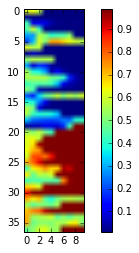

In [174]:
plt.imshow(disc.predict_fun(disc_X[::500]))
plt.colorbar()

In [94]:
batch = synthecised_phrases[:,:max_len]
disc_pred = disc.predict_fun(batch)

In [98]:
sel = np.argsort(-disc_pred[:,-1])[:100]

print '\n'.join(map(preproc.ix_to_phrase,batch[sel]))


okay okay jesus , uh , lay down on
so ? you mean , we be never an
i don't know , kyle , all right ?
hey , this means we can still still know
heheheheheh . he's such a douche , heheheheheh .
so then , we are all going to need
ey , get off of him , you fuckin'
now , token , i i know what you're
dude , craig , we should go back now
hm . work for you , have my penis
come on , let me kick you in the
i saw that picture of her you put on
kyle , i need to try to find a
well , i know one thing for sure .
aw , jesus , why don't you just cut
no , kitty , this is mah pot pie
don't worry , butters , i'm gonna get you
i'm not playing around , kyle ! if we
no ! no , i wanna . . .
and god is telling me that you have .
so then i can say , " what are
uh , butters , i don't know how to
yes , but if i believe that but the
'kay , thanks , i . . . wait
i really don't care anymore , butters . you
what do you mean ? have you ever seen
alright stan , i'm here i sit down .
heh yeah , he gotta do it look .
ey ! 

In [92]:
batch

array([7814, 3146, 4661, 8432, 3414, 8060, 1517, 5601, 6570, 2962,  784,
       7683, 8791,  880, 3087, 8704, 5532, 5460, 6265, 2584, 7598, 7684,
       6160,  402, 6712, 1660, 7094, 7974, 2273,  109, 5721, 5785,  479,
       5932, 1680, 6112, 5135, 3664,  103, 4949, 2744, 6232, 7959, 7828,
       6663, 5716, 6599, 1334, 5989, 3847, 2259, 8379, 2275, 2994, 5079,
        788, 2193,  243, 7762, 1495, 3696, 7875, 2880, 7849, 3547, 5469,
       3313, 4445, 4033,  561, 4240,   66, 8687, 1128, 6758, 7614, 8745,
       4602,  224, 8211, 5801,  883,  736, 2089, 5530, 3158, 2048, 2779,
       2156, 7005,  188, 7861, 3169, 6429,   24, 4491, 5199, 1167, 6331,
       8675])

In [14]:
model.greed.set_value(1.5)

Q = ["Who's Cartman?",
     "Who are you?",
     "what's up?",
     "Are you serious?",
     "What for?",
     "Do you know him?",
     "No!",
     "Fuck you, cartman",
     "What do you think?",
     "What a mess!",
     "",
     "Are you gay?",
     "They killed kenny!",
     "Jesus!"
    ]
for q in Q:
    print '>>',q
    print model.reply(q)

>> Who's Cartman?
beth ! bathroom ! the bathroom !
>> Who are you?
i am the dawg , the big bad dawg
>> what's up?
this is a jew , kenny ! you
>> Are you serious?
it wasn't . . . get my
>> What for?
i don't know . there's a know . there's
>> Do you know him?
it looks like kyle ! i was just
>> No!
a mountain lion ! okay
>> Fuck you, cartman
you broke the rules , how you found out
>> What do you think?
i don't know . like you like
>> What a mess!
i am too ! " the time the
>> 
next audition ! really ? you
>> Are you gay?
it wasn't ? ! god ! look
>> They killed kenny!
they fucking ! god damn it !
>> Jesus!
uh - oh . at least
